In [333]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skforecast import ForecasterAutoreg
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

# Data Loading and Preprocessing

In [334]:
df=pd.read_csv("dataset/train_set_rec.csv", nrows=1000)

In [335]:
df

,Timestamp,KPI_Value,Status,KPI_Name
0,2017-04-30 16:00:00,1.901639,0,Stamping Press Efficiency
1,2017-04-30 16:01:00,1.786885,0,Stamping Press Efficiency
2,2017-04-30 16:02:00,2.000000,0,Stamping Press Efficiency
3,2017-04-30 16:03:00,1.885246,0,Stamping Press Efficiency
4,2017-04-30 16:04:00,1.819672,0,Stamping Press Efficiency
...,...,...,...,...
995,2017-05-01 08:35:00,1.147541,0,Stamping Press Efficiency
996,2017-05-01 08:36:00,1.081967,0,Stamping Press Efficiency
997,2017-05-01 08:37:00,1.016393,0,Stamping Press Efficiency
998,2017-05-01 08:38:00,1.016393,0,Stamping Press Efficiency


In [336]:
df.shape

(1000, 4)

In [337]:
df['KPI_Name'].unique()

array(['Stamping Press Efficiency'], dtype=object)

In [338]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'] )

# sort by timestamp
df = df.sort_values(by='Timestamp',ascending=True)

# set timestamp as index
df.index = df['Timestamp']

In [339]:
df.describe(include='all')

C:\Users\E15\AppData\Local\Temp\ipykernel_13524\2884002236.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,Timestamp,KPI_Value,Status,KPI_Name
count,1000,1000.000000,1000.0,1000
unique,1000,NaN,NaN,1
top,2017-04-30 16:00:00,NaN,NaN,Stamping Press Efficiency
freq,1,NaN,NaN,1000
first,2017-04-30 16:00:00,NaN,NaN,NaN
last,2017-05-01 08:39:00,NaN,NaN,NaN
mean,NaN,2.351648,0.0,NaN
std,NaN,0.453847,0.0,NaN
min,NaN,0.967213,0.0,NaN
25%,NaN,2.147541,0.0,NaN


In [340]:
# verify the number of missing values in each column
nan_values = df.isna().sum()
nan_values>0

Timestamp    False
KPI_Value    False
Status       False
KPI_Name     False
dtype: bool

C:\Users\E15\AppData\Local\Temp\ipykernel_13524\3664052485.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['KPI_Value'], shade=True, color='b')


<Axes: xlabel='KPI_Value', ylabel='Density'>

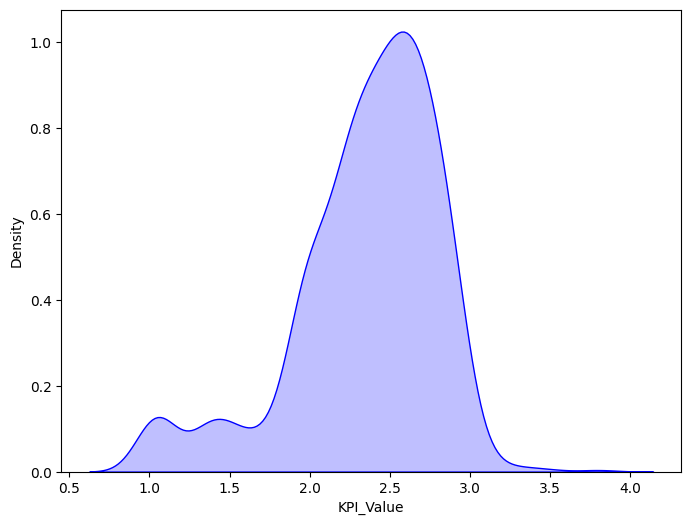

In [341]:
# plot the distribution of KPI values
plt.figure(figsize=(8, 6))
sns.kdeplot(df['KPI_Value'], shade=True, color='b')

In [342]:
# since the standard deviation is very high, we will normalize the KPI values
# using min-max scaling
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
df['KPI_Value'] = scaler.fit_transform(df[['KPI_Value']])

In [343]:
# normalizing KPI values
df['KPI_Value'].describe()

count    1000.000000
mean        0.488153
std         0.160027
min         0.000000
25%         0.416185
50%         0.514451
75%         0.601156
max         1.000000
Name: KPI_Value, dtype: float64

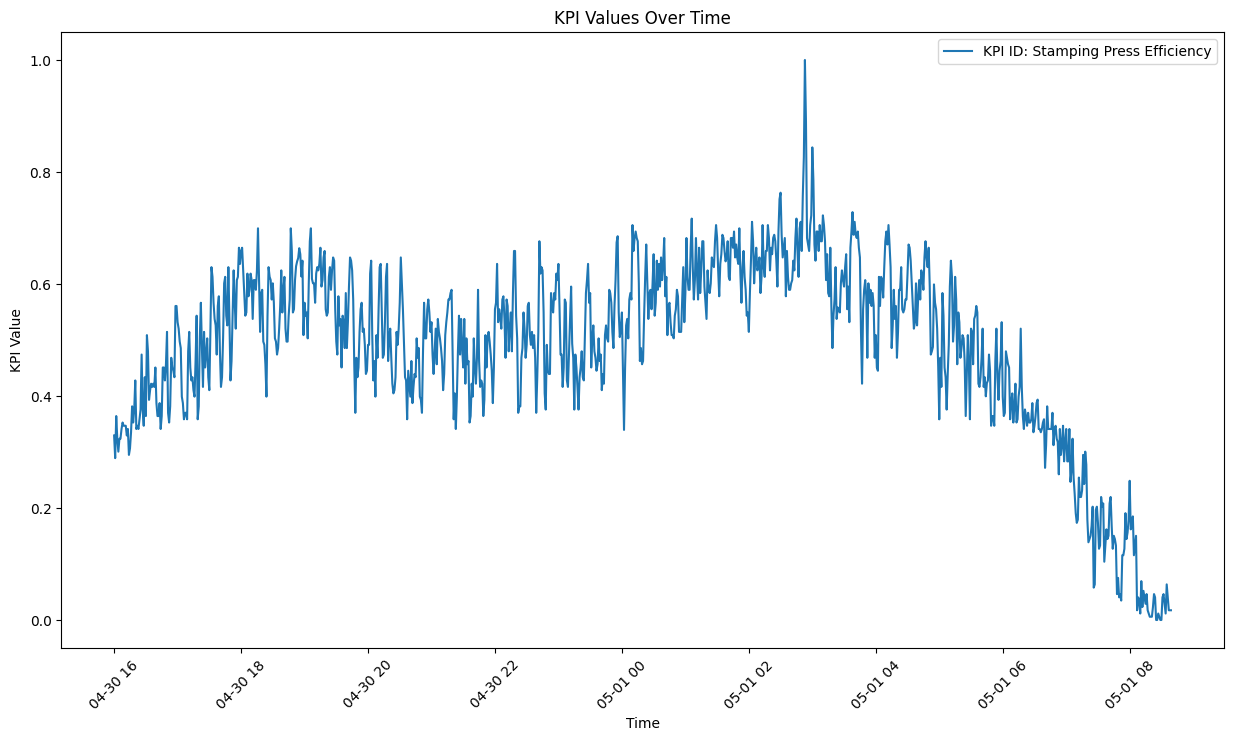

In [344]:
# Plot scaled KPI values over time for each KPI ID
unique_kpis = df['KPI_Name'].unique()

plt.figure(figsize=(15, 8))

for kpi in unique_kpis:
    plt.plot(df[df['KPI_Name'] == kpi]['Timestamp'], df[df['KPI_Name'] == kpi]['KPI_Value'], label=f'KPI ID: {kpi}')

plt.xlabel('Time')
plt.ylabel('KPI Value')
plt.title('KPI Values Over Time')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.show()

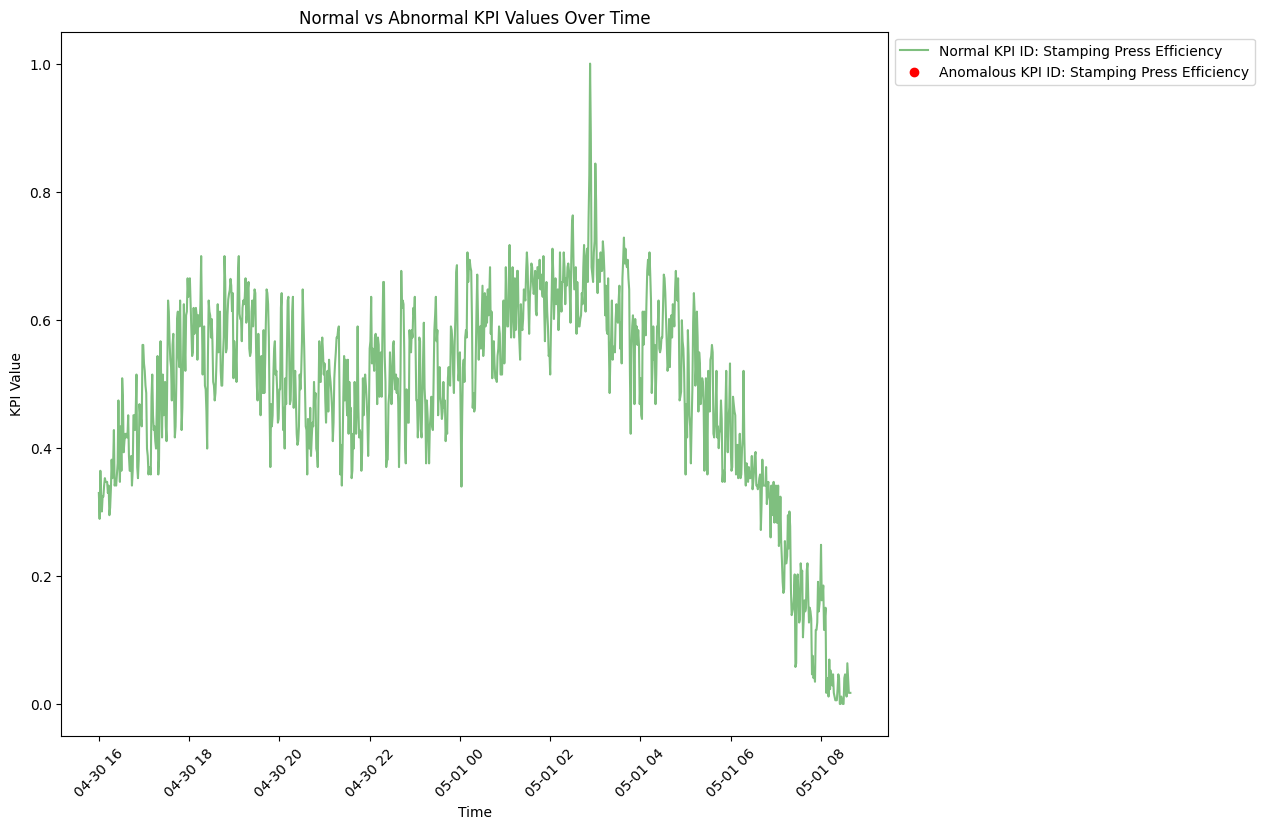

In [345]:
# Separate normal and abnormal data points
normal_data = df[df['Status'] == 0]
abnormal_data = df[df['Status'] == 1]

# Plot normal and abnormal points
plt.figure(figsize=(15, 8))


for kpi in unique_kpis:
    plt.plot(normal_data[normal_data['KPI_Name'] == kpi]['Timestamp'], 
             normal_data[normal_data['KPI_Name'] == kpi]['KPI_Value'], 
             label=f'Normal KPI ID: {kpi}', color='green', alpha=0.5)
    
    plt.scatter(abnormal_data[abnormal_data['KPI_Name'] == kpi]['Timestamp'], 
                abnormal_data[abnormal_data['KPI_Name'] == kpi]['KPI_Value'], 
                label=f'Anomalous KPI ID: {kpi}', color='red')
    
plt.xlabel('Time')
plt.ylabel('KPI Value')
plt.title('Normal vs Abnormal KPI Values Over Time')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.xticks(rotation=45)
plt.show()


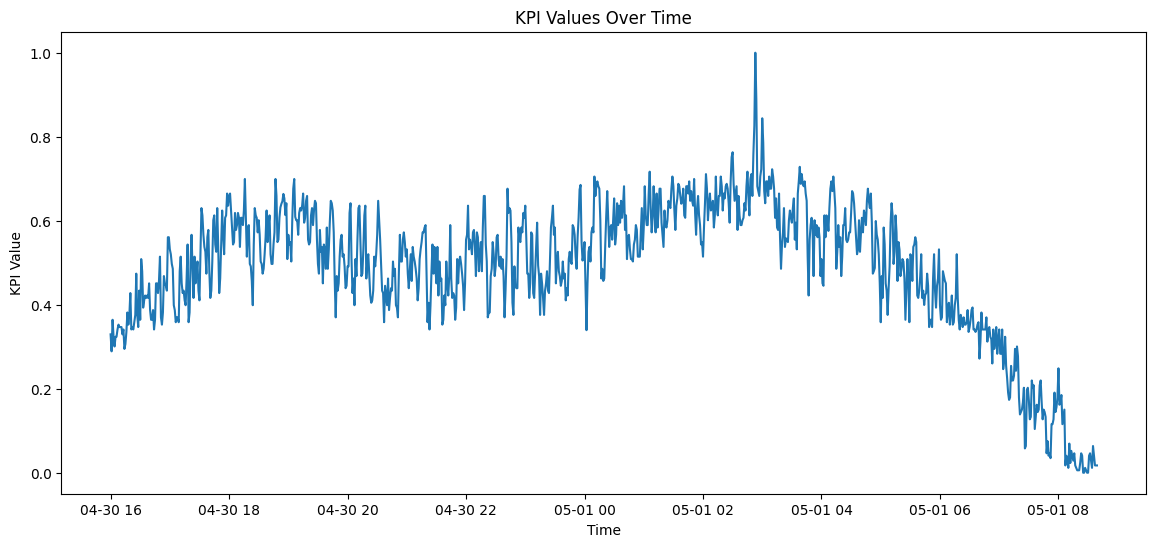

In [346]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df[df['Timestamp'] >= '2017-04-01']['KPI_Value'])
plt.title('KPI Values Over Time')
plt.xlabel('Time')
plt.ylabel('KPI Value')
plt.show()

# Feature Engineering

In [347]:
# rolling statistics
df['KPI_Value_mean'] = df['KPI_Value'].rolling(window=10).mean()
df['KPI_Value_std'] = df['KPI_Value'].rolling(window=10).std()
df.dropna(inplace=True)

In [348]:
time_step = 10
X, y = [], []
for i in range(len(df) - time_step):
    X.append(df['KPI_Value'].values[i:i + time_step])
    y.append(df['Status'].values[i + time_step])
X, y = np.array(X), np.array(y)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [349]:
# Split data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Model Selection and Training

In [350]:
# Function to create LSTM model
def create_model(units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(time_step, 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [351]:
units_options = [50, 100]
dropout_rate_options = [0.1, 0.2]
batch_size_options = [16, 32]
epochs_options = [50, 100]

In [352]:
best_f1 = 0
best_params = {}


In [353]:
for units in units_options:
    for dropout_rate in dropout_rate_options:
        for batch_size in batch_size_options:
            for epochs in epochs_options:
                print(f"Training with units={units}, dropout_rate={dropout_rate}, batch_size={batch_size}, epochs={epochs}")
                
                model = create_model(units=units, dropout_rate=dropout_rate)
                
                # Fit the model
                history = model.fit(X_train, y_train, 
                                    validation_split=0.2, 
                                    batch_size=batch_size, 
                                    epochs=epochs, 
                                    verbose=1)

                # Predictions and evaluation
                test_predict = (model.predict(X_test) > 0.5).astype(int)

                # Calculate F1 Score and Other Metrics
                test_f1 = f1_score(y_test, test_predict)
                test_precision = precision_score(y_test, test_predict)
                test_recall = recall_score(y_test, test_predict)

                print(f"F1 Score: {test_f1}, Precision: {test_precision}, Recall: {test_recall}")

                # Check for best F1 score
                if test_f1 > best_f1:
                    best_f1 = test_f1
                    best_params = {
                        'units': units,
                        'dropout_rate': dropout_rate,
                        'batch_size': batch_size,
                        'epochs': epochs
                    }

print(f"Best F1 Score: {best_f1} with params: {best_params}")


Training with units=50, dropout_rate=0.1, batch_size=16, epochs=50
Epoch 1/50
40/40 [==============================] - 6s 40ms/step - loss: 0.2183 - accuracy: 0.9793 - val_loss: 3.9576e-04 - val_accuracy: 1.0000
Epoch 2/50
40/40 [==============================] - 0s 11ms/step - loss: 2.8083e-04 - accuracy: 1.0000 - val_loss: 1.7602e-04 - val_accuracy: 1.0000
Epoch 3/50
40/40 [==============================] - 1s 13ms/step - loss: 1.8689e-04 - accuracy: 1.0000 - val_loss: 1.4559e-04 - val_accuracy: 1.0000
Epoch 4/50
40/40 [==============================] - 1s 15ms/step - loss: 1.6307e-04 - accuracy: 1.0000 - val_loss: 1.2598e-04 - val_accuracy: 1.0000
Epoch 5/50
40/40 [==============================] - 0s 12ms/step - loss: 1.4440e-04 - accuracy: 1.0000 - val_loss: 1.1169e-04 - val_accuracy: 1.0000
Epoch 6/50
40/40 [==============================] - 0s 11ms/step - loss: 1.2521e-04 - accuracy: 1.0000 - val_loss: 1.0049e-04 - val_accuracy: 1.0000
Epoch 7/50
40/40 [=========================

KeyboardInterrupt: 

In [324]:
# Function to detect anomalies
def detect_anomalies(y_true, y_pred, threshold=0.5):
    anomalies = (y_true != y_pred.flatten()).astype(int)  # 1 for anomaly, 0 for normal
    return anomalies

In [325]:
# Get predictions on the test set
predictions = model.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int)

# Detect anomalies
anomalies = detect_anomalies(y_test, predicted_classes)

7/7 [==============================] - 0s 11ms/step


In [326]:
test_dates = df['Timestamp'].iloc[len(df) - len(y_test):].values
results_df = pd.DataFrame({
    'Timestamp': test_dates,
    'Actual': y_test,
    'Predicted': predicted_classes.flatten(),
    'Anomaly': anomalies
})

In [327]:
# Set Timestamp as index for easier plotting
results_df.set_index('Timestamp', inplace=True)

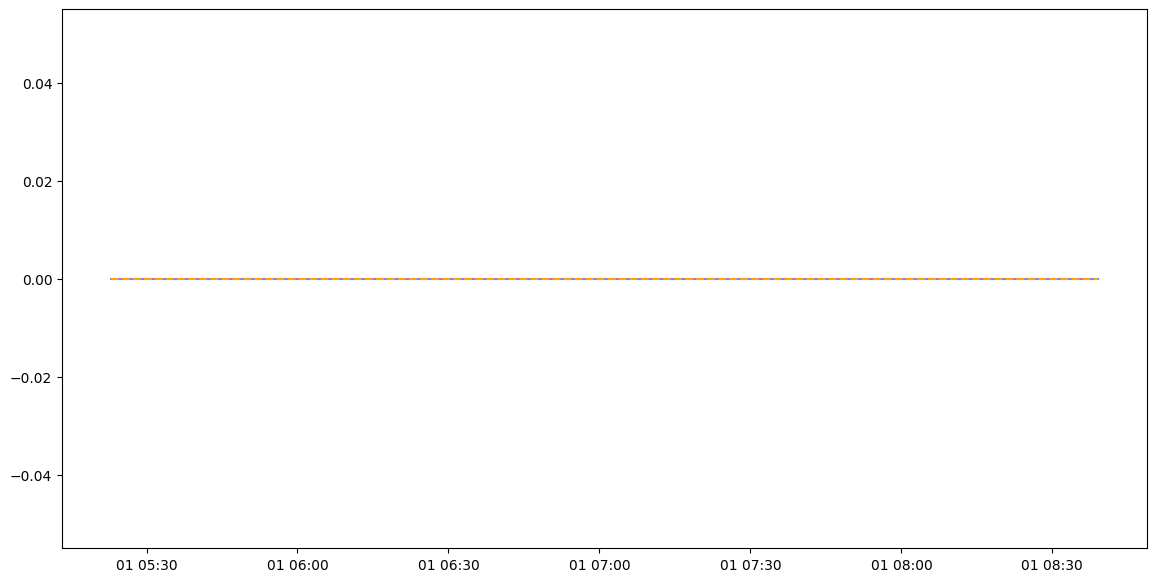

In [328]:
# Plot actual vs predicted values with anomalies
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Actual'], label='Actual Status', color='blue', alpha=0.5)
plt.plot(results_df.index, results_df['Predicted'], label='Predicted Status', color='orange', linestyle='--')


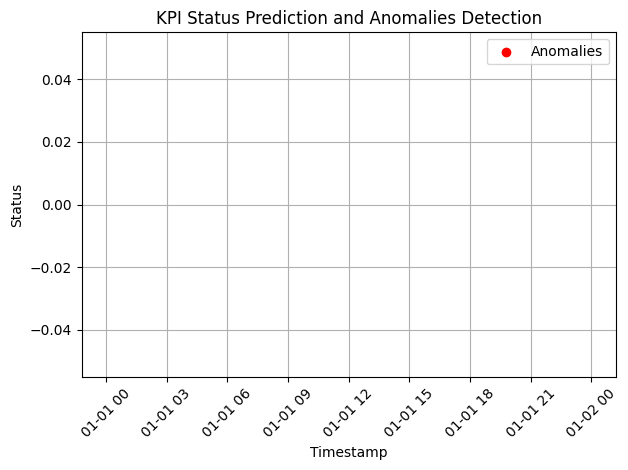

In [329]:
# Highlight anomalies
anomaly_indices = results_df[results_df['Anomaly'] == 1].index
plt.scatter(anomaly_indices, results_df.loc[anomaly_indices]['Predicted'], color='red', label='Anomalies', marker='o')

plt.title('KPI Status Prediction and Anomalies Detection')
plt.xlabel('Timestamp')
plt.ylabel('Status')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [332]:
import joblib

# Save the model
joblib.dump(model, 'lstm_model.h5')
# save scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']